# Load MNIST data

In [6]:
import torchvision
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.ToTensor()

# MNIST - Train data
trainset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

# MNIST - Test data
testset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Classes
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [7]:
print(f"Train size: {len(trainset)}, Test size: {len(testset)}")

Train size: 60000, Test size: 10000


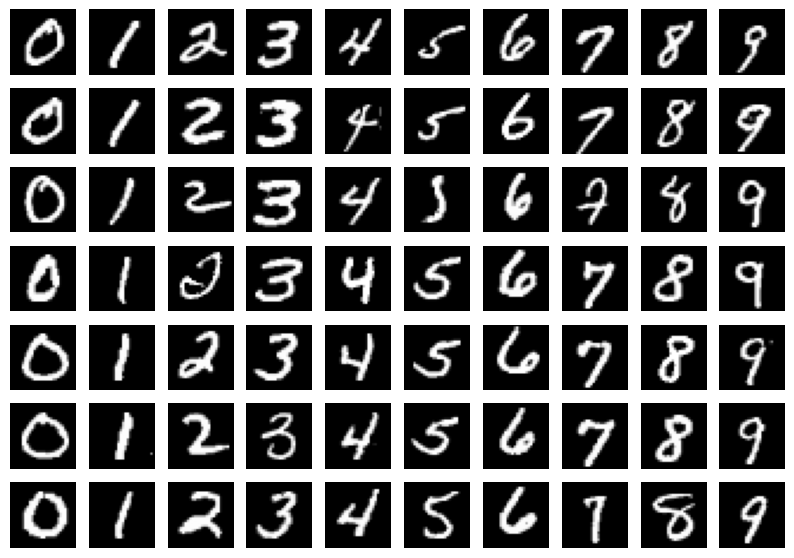

In [8]:
fig, axes = plt.subplots(7, 10, figsize=(10, 7))
j = 0

for i, ax in enumerate(axes.flat):
    image, label = trainset[j]
    while label != i % 10:
        j += 1
        image, label = trainset[j]

    ax.imshow(image[0], cmap='gray')
    ax.axis('off')

plt.show()

In [9]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=3, padding=1)
        self.AvgPool1 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=9, out_channels=36, kernel_size=5)
        self.AvgPool2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=36, out_channels=72, kernel_size=2)

        self.Flatten = nn.Flatten()

        self.fc1 = nn.Linear(72*4*4, 96)
        self.fc2 = nn.Linear(96, 10)

        self.tanh = nn.Tanh()


    def forward(self, x):
        x = self.tanh(self.conv1(x))
        x = self.AvgPool1(x)
        x = self.tanh(self.conv2(x))
        x = self.AvgPool2(x)
        x = self.tanh(self.conv3(x))

        x = self.Flatten(x)
        x = self.tanh(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)

        return x

In [12]:
trunk = LeNet5()

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, num_epochs=2):
    for epoch in range(num_epochs):
        model.train()
        for i, data in enumerate(train_loader):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if i % 2000 == 1999:
                print(f"Epoch {epoch+1}, batch {i+1}, loss: {loss.item()}")
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        print(f"Epoch {epoch+1}, accuracy: {accuracy:.2f}%")

criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(trunk.parameters(), lr=0.01)

# Pass parameters to run
train_and_evaluate(trunk, trainloader, testloader, criteria, optimizer, num_epochs=30)


Epoch 1, accuracy: 44.08%
Epoch 2, accuracy: 51.57%
Epoch 3, accuracy: 83.09%
Epoch 4, accuracy: 88.27%
Epoch 5, accuracy: 89.92%
Epoch 6, accuracy: 90.82%
Epoch 7, accuracy: 91.65%
Epoch 8, accuracy: 92.07%
Epoch 9, accuracy: 92.72%
Epoch 10, accuracy: 93.05%
Epoch 11, accuracy: 93.37%
Epoch 12, accuracy: 93.73%
Epoch 13, accuracy: 94.13%
Epoch 14, accuracy: 94.37%
Epoch 15, accuracy: 94.51%
Epoch 16, accuracy: 94.83%
Epoch 17, accuracy: 95.02%
Epoch 18, accuracy: 95.20%
Epoch 19, accuracy: 95.26%
Epoch 20, accuracy: 95.53%
Epoch 21, accuracy: 95.68%
Epoch 22, accuracy: 95.79%
Epoch 23, accuracy: 95.91%
Epoch 24, accuracy: 96.16%
Epoch 25, accuracy: 96.27%
Epoch 26, accuracy: 96.42%
Epoch 27, accuracy: 96.50%
Epoch 28, accuracy: 96.61%
Epoch 29, accuracy: 96.73%
Epoch 30, accuracy: 96.82%


NameError: name 'inputs' is not defined